# ASFPM 2020

In [1]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from utils import *
import os
from IPython.display import Image

### Enter Station ID 

In [2]:
gage = "01646500"
state = "MD"

gage_url = f'https://waterdata.usgs.gov/nwis/inventory?agency_code=USGS&site_no={gage}'
Url(gage_url)

Url(_Url__url='https://waterdata.usgs.gov/nwis/inventory?agency_code=USGS&site_no=01646500')

### Generate URL and read data

In [3]:
stats_uri = f'https://nwis.waterdata.usgs.gov/{state}/nwis/peak?site_no={gage}&agency_cd=USGS&format=rdb'
Url(stats_uri)

Url(_Url__url='https://nwis.waterdata.usgs.gov/MD/nwis/peak?site_no=01646500&agency_cd=USGS&format=rdb')

In [4]:
peaks = pd.read_table(stats_uri, comment = "#")
peaks = peaks[1:].reset_index(drop=True)
peaks['peak_va'] = pd.to_numeric(peaks['peak_va'] )
peaks['peak_dt'] = pd.to_datetime(peaks['peak_dt'])
peaks.head()

agency_cd   site_no    peak_dt peak_tm  peak_va peak_cd gage_ht gage_ht_cd  \
0      USGS  01646500 1931-04-03     NaN    37900     NaN    6.90        NaN   
1      USGS  01646500 1932-05-14     NaN   168000     NaN   15.25        NaN   
2      USGS  01646500 1933-04-22     NaN   127000     NaN   12.80        NaN   
3      USGS  01646500 1934-09-18     NaN    53500     NaN    7.80        NaN   
4      USGS  01646500 1934-12-02     NaN   139000     NaN   13.50        NaN   

  year_last_pk ag_dt ag_tm ag_gage_ht ag_gage_ht_cd  
0          NaN   NaN   NaN        NaN           NaN  
1          NaN   NaN   NaN        NaN           NaN  
2          NaN   NaN   NaN        NaN           NaN  
3          NaN   NaN   NaN        NaN           NaN  
4          NaN   NaN   NaN        NaN           NaN

# View Annual Maxima

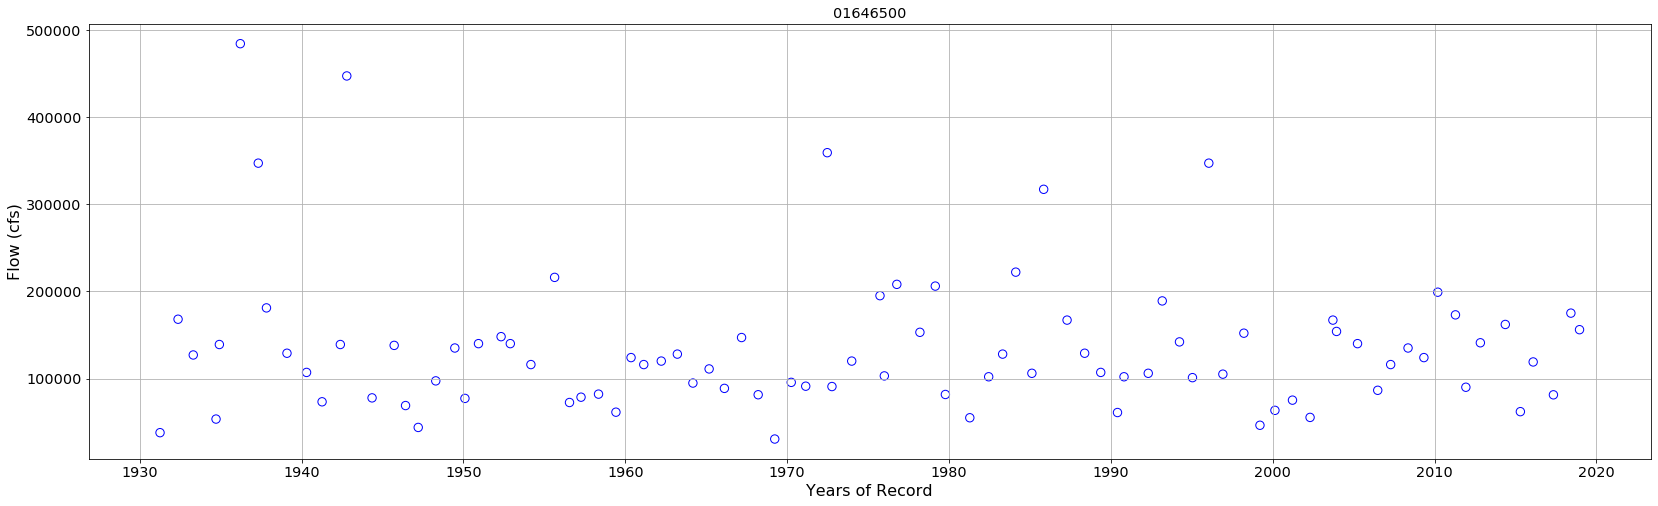

In [5]:
fig, ax = plt.subplots(figsize=(28,8))
ax.scatter(x= peaks.peak_dt.values, y = peaks.peak_va.values,  color="none", edgecolor="blue", s= 70);ax.grid();
ax.set_title(gage);ax.set_ylabel('Flow (cfs)', fontsize=16);ax.set_xlabel('Years of Record', fontsize=16);
# ax.axhline(250000, 0,365, color='red')

# Select a year and plot the mean daily flow

In [6]:
year= 1996
# Auto generate url string
daily_uri = f"https://waterdata.usgs.gov/{state}/nwis/dv?cb_00060=on&format=rdb&site_no={gage}&referred_module=sw&period=&begin_date={year-1}-10-01&end_date={year}-9-30"
Url(daily_uri)

Url(_Url__url='https://waterdata.usgs.gov/MD/nwis/dv?cb_00060=on&format=rdb&site_no=01646500&referred_module=sw&period=&begin_date=1995-10-01&end_date=1996-9-30')

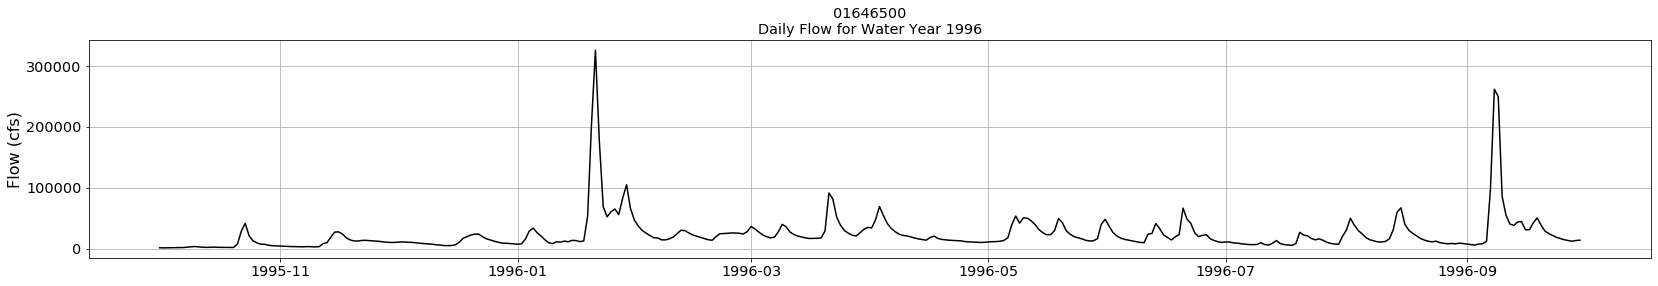

In [7]:
daily = pd.read_table(daily_uri, comment = "#")
daily = daily[1:].reset_index(drop=True)
daily['datetime'] = pd.to_datetime(daily['datetime'])
flow_col = daily.columns[3]
daily[flow_col] = pd.to_numeric(daily[flow_col]) 

fig, ax = plt.subplots(figsize=(28,4))
ax.plot(daily.datetime,daily[flow_col].values,  color="black");ax.grid();
ax.set_title(f'{gage}\nDaily Flow for Water Year {year}');ax.set_ylabel('Flow (cfs)', fontsize=16);
# ax.axhline(250000, 0,365, color='red');

# Sort and Rank the Peak Annual Flows

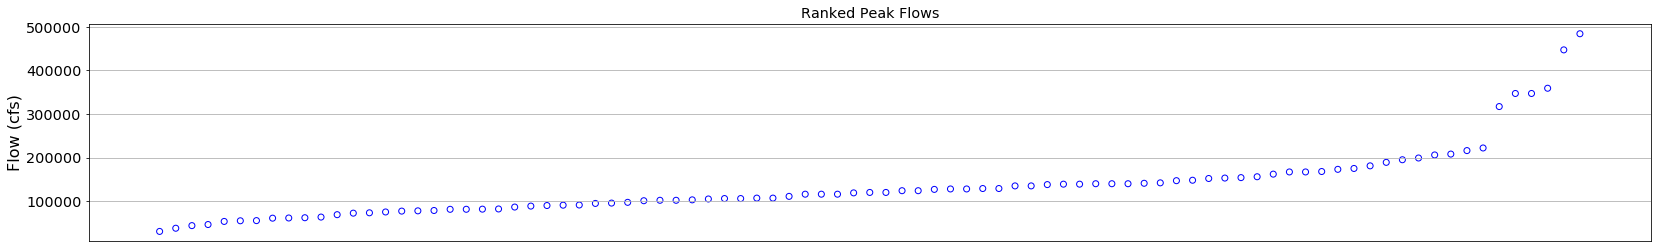

In [8]:
fig, ax = plt.subplots(figsize=(28,4))
ax.scatter(x= np.arange(0, len(peaks.peak_va)), y = sorted(peaks.peak_va.values, reverse=True),  color="none", edgecolor="blue");ax.invert_xaxis()
ax.set_xlabel(f"{len(peaks.peak_va)} Samples");ax.set_ylabel('Flow (cfs)', fontsize=16);ax.grid();ax.set_title("Ranked Peak Flows");ax.get_xaxis().set_visible(False)

### Calculate the Empirical Distribution

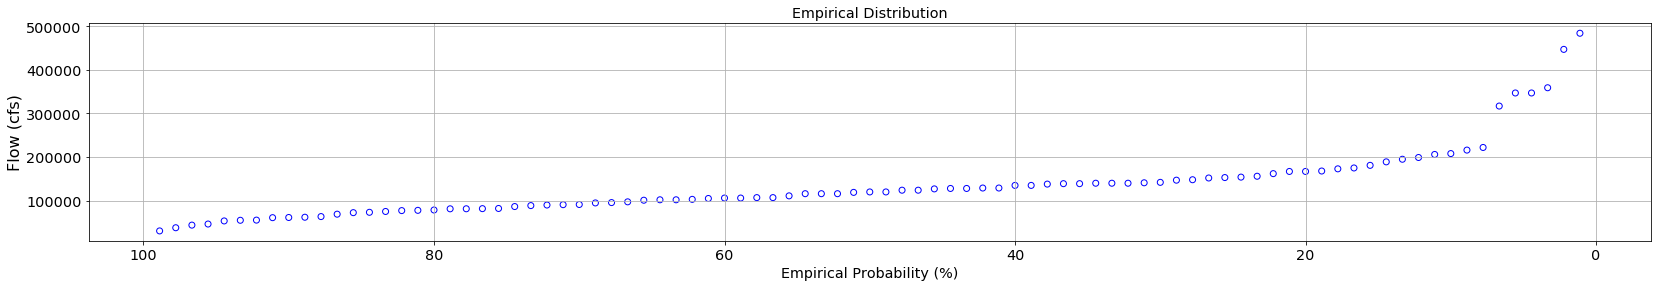

In [9]:
def ecdf(data):
    """ Compute ECDF """
    x = sorted(data, reverse=True)
    n = len(data)
    y = np.arange(1, n+1) / (n+1)
    return x, y

emp_q, emp_ri = ecdf(peaks.peak_va)
fig, ax = plt.subplots(figsize=(28,4))
ax.scatter(x= emp_ri*100, y = emp_q,  color="none", edgecolor="blue");ax.invert_xaxis()
ax.set_xlabel(f"Empirical Probability (%)");ax.set_ylabel('Flow (cfs)', fontsize=16);ax.grid();ax.set_title("Empirical Distribution");

### Convert to log & compute moments

In [10]:
# Look up regional skew & mse for station
rskew = 0.55
rskew_mse = 0.2025

In [11]:
lp3_data = LP3(peaks.peak_va)

log_peaks = lp3_data.log
skew =  lp3_data.weighted_skew(rskew, rskew_mse)
mu = lp3_data.log.mean()
sigma = lp3_data.log.std()

print(f"Mean (Log): \t\t{mu}\nStandard Deviation: \t{sigma}\nStation Skew: \t\t{skew}")

Mean (Log): 		5.071491722982058
Standard Deviation: 	0.22284509421165621
Station Skew: 		0.30873558445993743


### Calculate LPII and Plot

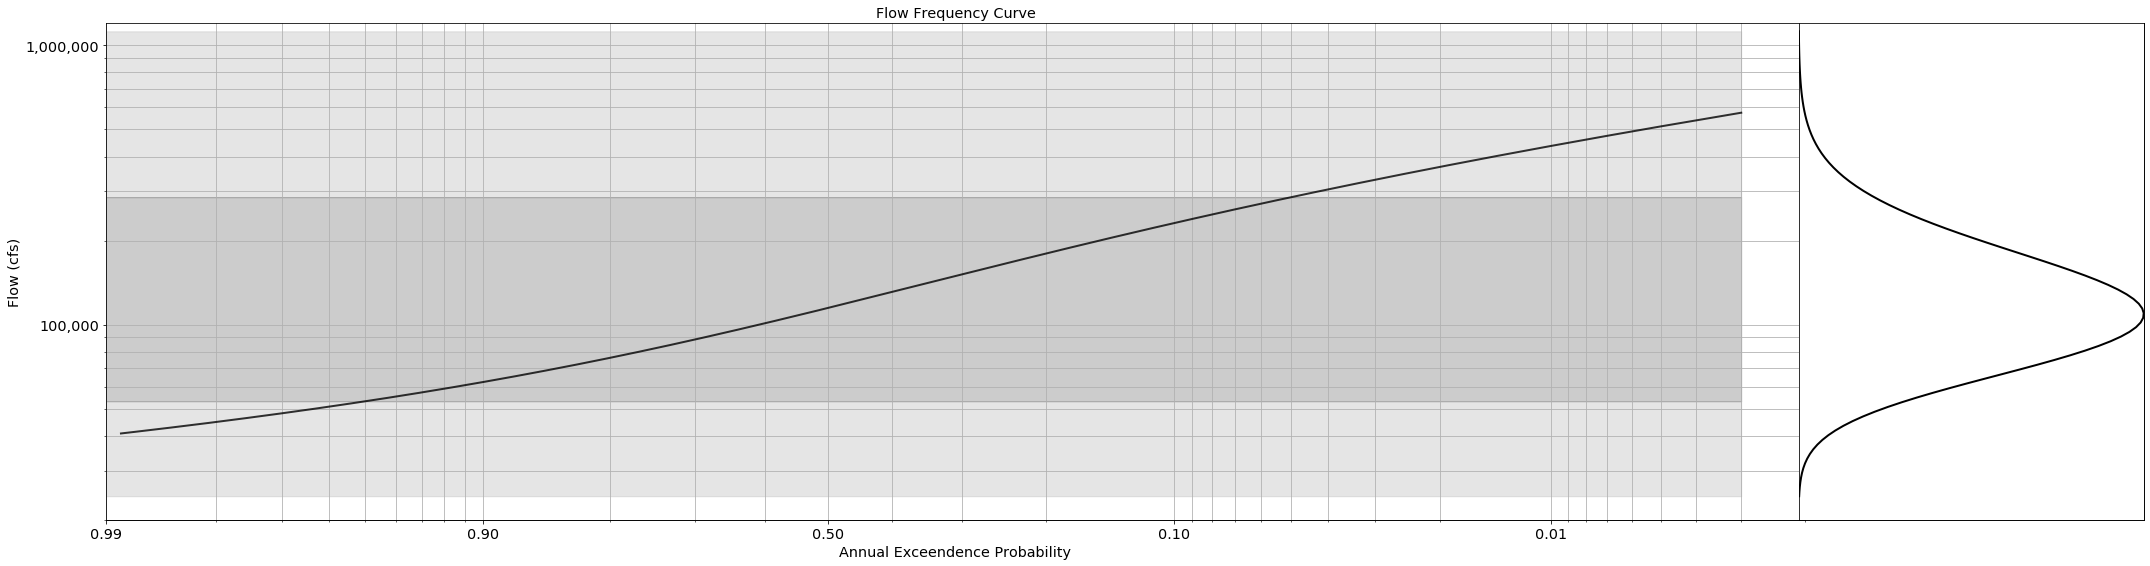

In [12]:
# LPII Curve using Gage moments
aeps = np.arange(0.002, 1, .001)
aep_qs = lp3_data.lp3_values(aeps, rskew, rskew_mse)
plot_aep_full(aeps, aep_qs, skew, mu, sigma, color = "Brown", ci=95);
# fig, ax = add_emperical_plot_full;

# Plot the PDF with the Observed Data

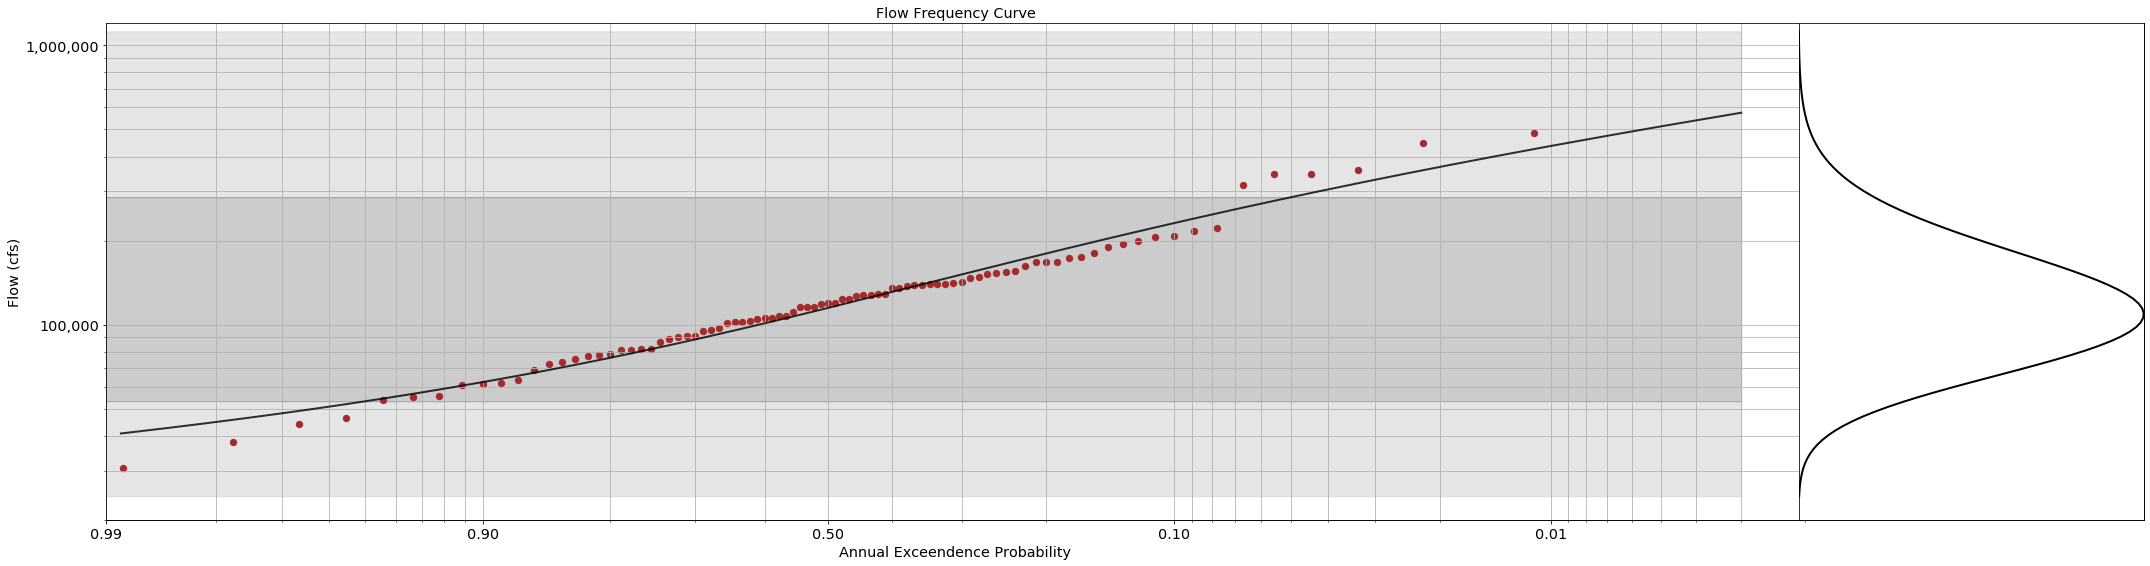

In [13]:
# f, a = plot_aep_full(aeps, aep_qs, skew, mu, sigma)
add_emperical_plot_full(aeps, aep_qs, emp_q,emp_ri, skew, mu, sigma, color = "Brown");

### Boostrapping

### Boostrap Method #1

### Select random variates by choosing a subset of the Gage Records

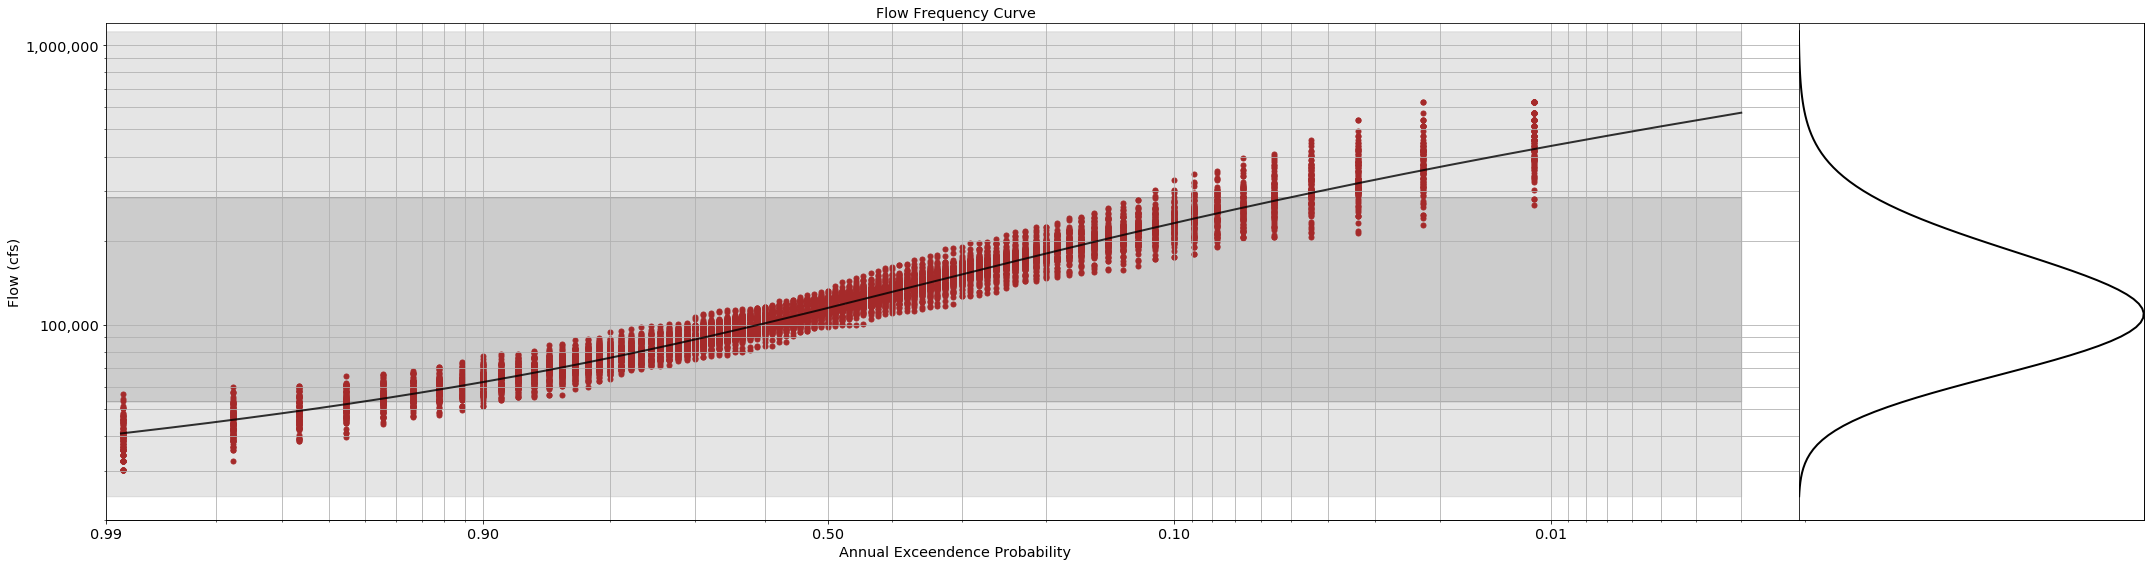

In [14]:
n= 89
bootstraps = 100
data = add_boostrap_plot_from_sample_pop_full(aeps, aep_qs, skew, mu, sigma, nbs=bootstraps, nsamples=n, color = 'brown')

### Boostrap Method #2

### Select random variates generated using the LP III Distribution calculated from the Gage Records

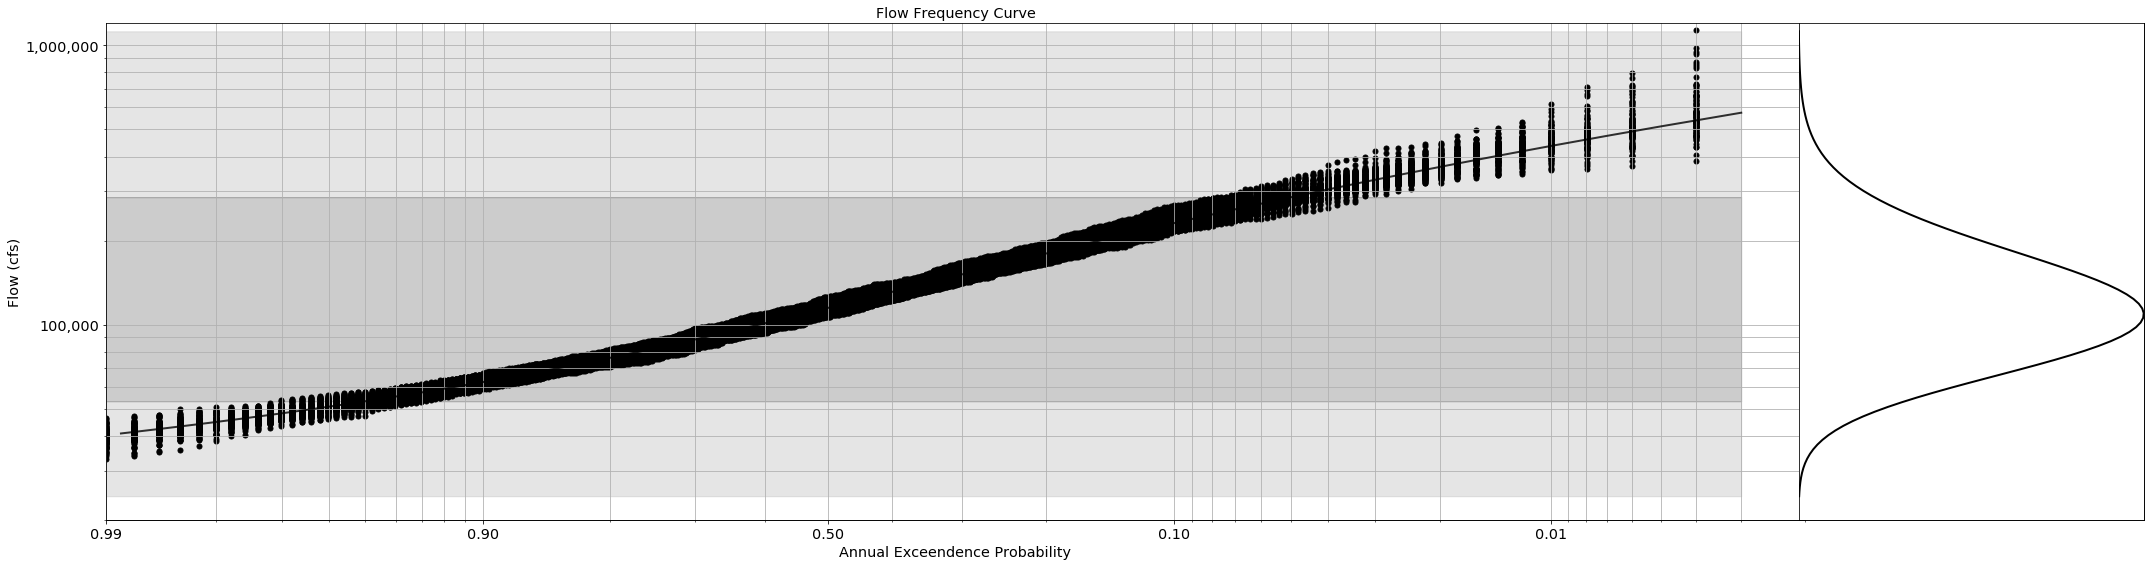

In [15]:
n= 500
bootstraps = 100
data = add_boostrap_plot_full(aeps, aep_qs, skew, mu, sigma,  nbs=bootstraps, nsamples=n, color = 'black')

### Realizations

In [21]:
%%capture
n= 89
image_list, image_files = [],[]
bootstraps = 500

root = os.getcwd()
gifdir = pl.Path(root)

realizations = 10

for i in range(realizations):
    data = add_boostrap_plot_full(aeps, aep_qs, skew, mu, sigma, nbs=bootstraps, nsamples=n, color='brown')
    img = gifdir/"images"/f'{i}.png' 
    data[0].savefig(img)
    image_files.append(img)
    image_list.append(imageio.imread(img))

imageio.mimwrite(gifdir/f'boostraps.gif', image_list)

In [22]:
# Clean up temporay files
for image in image_files:
    os.remove(image)

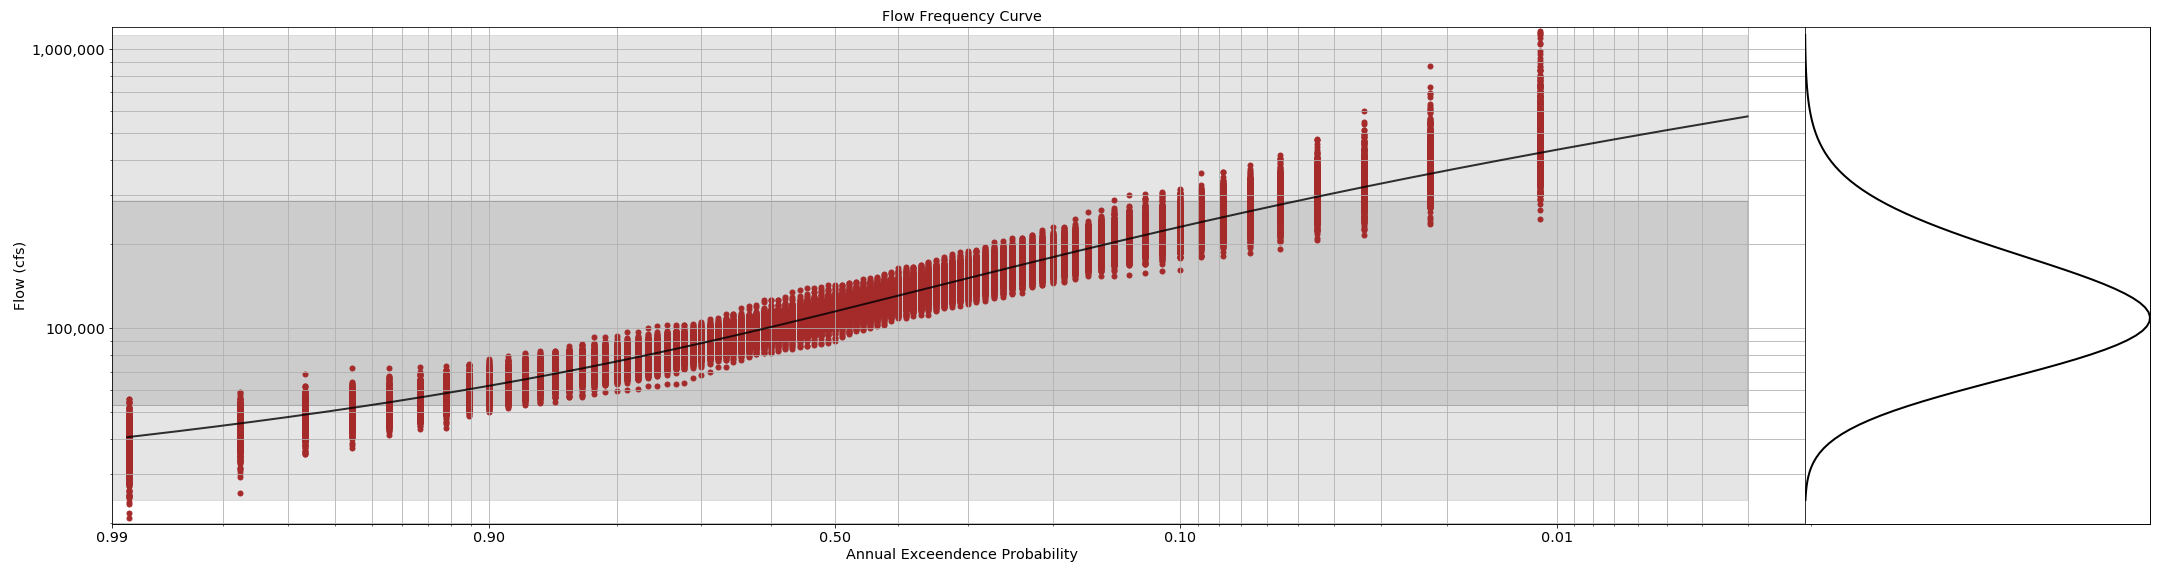

In [24]:
with open(gifdir/"images"/"boostraps.gif",'rb') as file:
    display(Image(file.read()))

### Confidence for Each Recurrence Interval

In [19]:
n= 89
bootstraps = 1
realizations = []
for i in range(1000):
    r = np.random.choice(aep_qs, size=n)
    emp_q,emp_ri  = ecdf(r)
    realizations.append(dict(zip(emp_ri,sorted(emp_q,reverse=True))))
    
    
df = pd.DataFrame(realizations).T
df.head()

0              1              2              3    \
0.011111  626197.871466  626197.871466  382963.341933  358457.889105   
0.022222  574064.982305  436364.292451  343055.381339  339625.933830   
0.033333  311692.363093  336338.462441  333182.288497  333182.288497   
0.044444  309383.767922  327226.650237  298792.480322  319068.759086   
0.055556  257578.358670  300794.821269  298792.480322  291280.912828   

                    4              5              6              7    \
0.011111  574064.982305  367411.269132  512655.937277  327226.650237   
0.022222  491830.796693  333182.288497  350389.758858  321693.727901   
0.033333  460083.951451  321693.727901  339625.933830  307143.273503   
0.044444  362812.705764  304967.181845  321693.727901  294941.915280   
0.055556  311692.363093  263413.541285  314073.076727  279734.129711   

                    8              9    ...            990            991  \
0.011111  377452.144648  436364.292451  ...  382963.341933  460083.951451   
0.022222  354323.609519  426466.413588  ...  358457.889105  358457.889105   
0.033333  311692.363093  409446.220920  ...  350389.758858  296842.350692   
0.044444  289516.120893  409446.220920  ...  346638.806571  275294.689096   
0.055556  286108.405095  358457.889105  ...  336338.462441  255372.704537   

                    992            993            994            995  \
0.011111  447467.430180  512655.937277  426466.413588  512655.937277   
0.022222  447467.430180  330147.870596  377452.144648  362812.705764   
0.033333  372280.553210  314073.076727  350389.758858  311692.363093   
0.044444  346638.806571  267159.268096  327226.650237  307143.273503   
0.055556  343055.381339  253234.030849  302852.081969  300794.821269   

                    996            997            998            999  
0.011111  333182.288497  436364.292451  512655.937277  626197.871466  
0.022222  319068.759086  327226.650237  474653.163832  293088.830909  
0.033333  244344.277249  300794.821269  324410.922622  249142.802926  
0.044444  242513.873945  294941.915280  261021.549720  239855.841009  
0.055556  236463.749349  293088.830909  253234.030849  238138.946000  

[5 rows x 1000 columns]

In [20]:
x0 = df.iloc[0].values